ANÁLISE EXPLORATÓRIA: COMPORTAMENTOS DE CLIENTES E SEGMENTOS

IMPORTS

In [26]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sea
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#StandardScaler (do sklearn.preprocessing):

#Serve para padronizar os dados (colocar tudo na mesma escala com média 0 e desvio padrão 1). Isso é essencial para algoritmos como o KMeans, que são sensíveis a escalas diferentes.

#KMeans (do sklearn.cluster):

#É um algoritmo de clusterização que agrupa dados em k grupos com base em semelhanças. Aqui, ele agrupou os clientes com base em recência, frequência e valor.

DATA FRAME

In [27]:
df = pd.read_excel("../Proj2.xlsx")

INFORMAÇÕES QUE DESEJAMOS CONSEGUIR NESSA ETAPA:

Qual segmento (Consumidor, Corporativo, Home Office) gera:

    Mais receita

    Maior ticket médio

    Maior margem média

Top clientes:

    Valor total

    Frequência de pedidos

    Ideal para pensar em fidelização ou VIPs

Agrupar clientes em clusters:

    Recente e frequente “Clientes VIP”

    Pouco recente, alta frequência  “Potencial churn”

    Baixa frequência e valor “Clientes novos ou fracos”

TÓPICO 1:

In [28]:
segmentos = df.groupby('segmento').agg({
    'vendas': 'sum',
    'lucro': 'sum',
    'id_pedido': 'nunique'
}).reset_index()

segmentos['ticket_medio'] = segmentos['vendas'] / segmentos['id_pedido']
segmentos['margem'] = segmentos['lucro'] / segmentos['vendas']

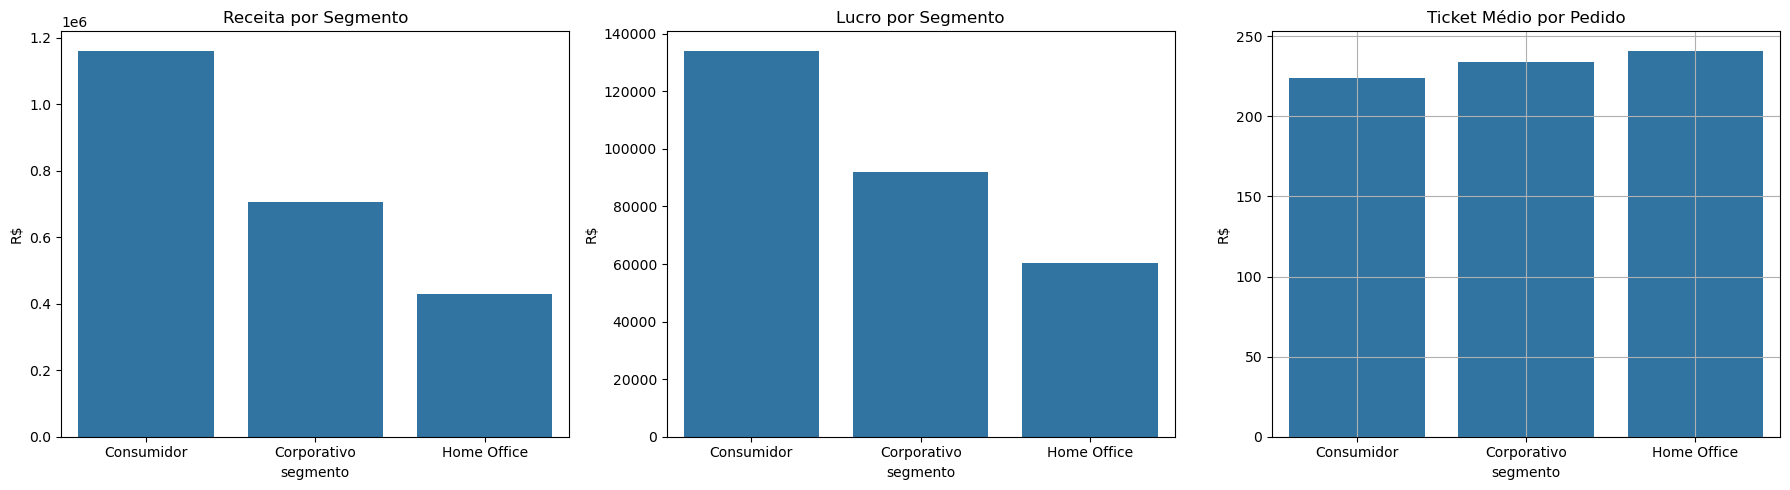

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

#receita
sea.barplot(x='segmento', y='vendas', data=segmentos, ax=axs[0])
axs[0].set_title('Receita por Segmento')
axs[0].set_ylabel('R$')

#lucro
sea.barplot(x='segmento', y='lucro', data=segmentos, ax=axs[1])
axs[1].set_title('Lucro por Segmento')
axs[1].set_ylabel('R$')

#ticmédio
sea.barplot(x='segmento', y='ticket_medio', data=segmentos, ax=axs[2])
axs[2].set_title('Ticket Médio por Pedido')
axs[2].set_ylabel('R$')
plt.grid(True)
plt.tight_layout()
plt.show()

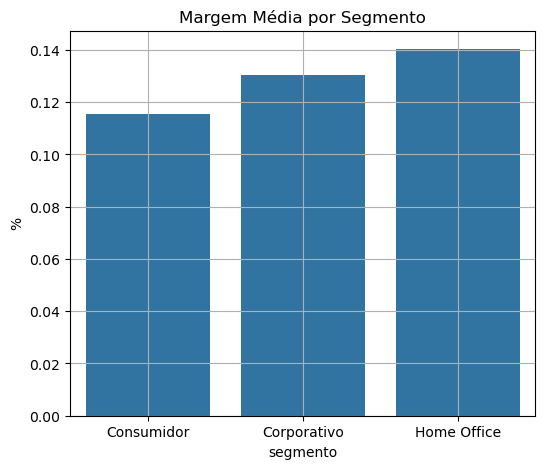

In [30]:
plt.figure(figsize=(6,5))
sea.barplot(x='segmento', y='margem', data=segmentos)
plt.title('Margem Média por Segmento')
plt.ylabel('%')
plt.grid(True)
plt.show()



- O segmento Consumidor lidera em volume de vendas e lucro absoluto, porém apresenta o menor ticket médio por pedido e a menor margem média, o que indica menor eficiência financeira por venda.
- Já o segmento Home Office, apesar de ter menor volume de vendas, possui o maior ticket médio e a melhor margem, o que o torna altamente rentável por pedido.
- O segmento Corporativo fica em uma posição intermediária, equilibrando bem volume e rentabilidade.

Esses dados indicam que estratégias como campanhas promocionais, upsell e fidelização podem ser segmentadas com mais inteligência, priorizando margens em vez de apenas volume.


TÓPICO 2:

In [31]:
top_clientes = df.groupby('nome_cliente').agg({
    'vendas': 'sum',
    'id_pedido': 'nunique'
}).rename(columns={
    'vendas': 'total_gasto',
    'id_pedido': 'qtd_pedidos'
}).sort_values(by='total_gasto', ascending=False).head(10)

top_clientes

,total_gasto,qtd_pedidos
nome_cliente,,
Harold Dahlen,36521.6425,36
Clytie Kelty,26791.6070,24
Karl Brown,24383.7630,37
Ed Braxton,22441.4620,46
Christy Brittain,18250.8500,30
Joe Elijah,17862.3020,12
Scott Cohen,15587.1690,16
Giulietta Dortch,15052.4260,32
Bill Eplett,15027.7620,24


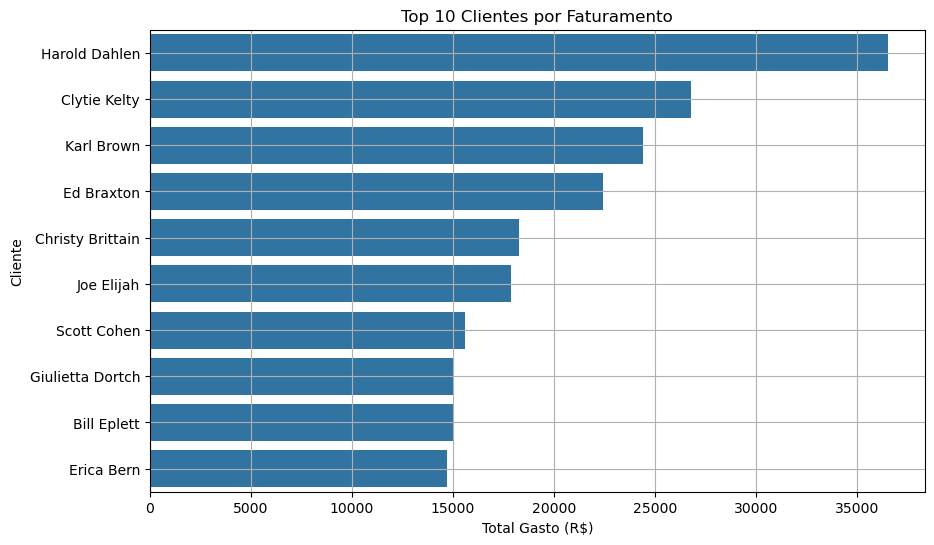

In [32]:
plt.figure(figsize=(10,6))
sea.barplot(x=top_clientes['total_gasto'], y=top_clientes.index)
plt.title('Top 10 Clientes por Faturamento')
plt.xlabel('Total Gasto (R$)')
plt.ylabel('Cliente')
plt.grid(True)
plt.show()

In [33]:
top_frequencia = df.groupby('nome_cliente')['id_pedido'].nunique().reset_index()
top_frequencia = top_frequencia.rename(columns={'id_pedido': 'qtd_pedidos'})
top_frequencia = top_frequencia.sort_values(by='qtd_pedidos', ascending=False).head(10)


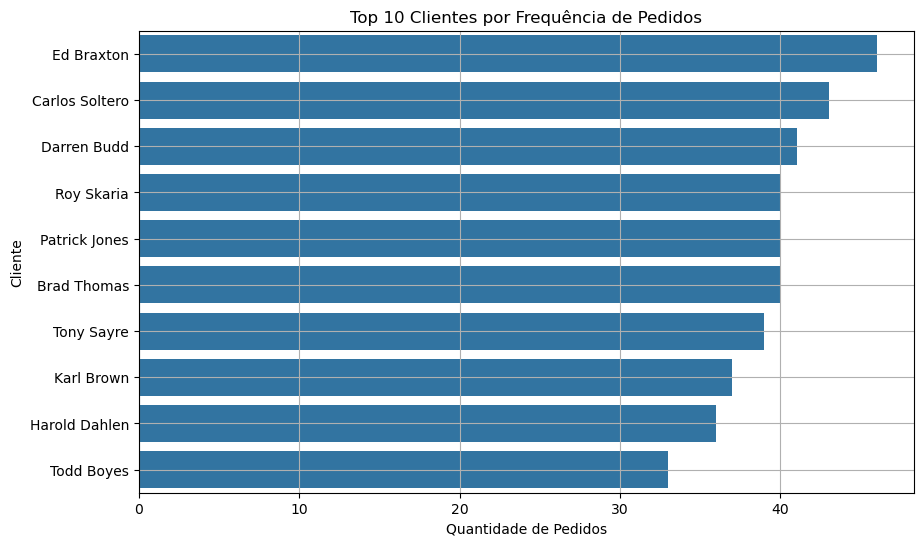

In [34]:
plt.figure(figsize=(10,6))
sea.barplot(x='qtd_pedidos', y='nome_cliente', data=top_frequencia)
plt.title('Top 10 Clientes por Frequência de Pedidos')
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Cliente')
plt.grid(True)
plt.show()

TÓPICO 3:

In [35]:

rfm = df.groupby('nome_cliente').agg({
    'id_pedido': 'nunique',   # frequência
    'vendas': 'sum'           # valor total gasto
}).reset_index()

rfm.columns = ['cliente', 'frequencia', 'valor']

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['frequencia', 'valor']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

def rotulo_cluster(linha):
    if linha['cluster'] == 1:
        return 'VIP'
    elif linha['cluster'] == 2:
        return 'Bom Cliente'
    elif linha['cluster'] == 3:
        return 'Oportunidade'
    else:
        return 'Fraco'

rfm['perfil'] = rfm.apply(rotulo_cluster, axis=1)



c:\Users\joaoh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


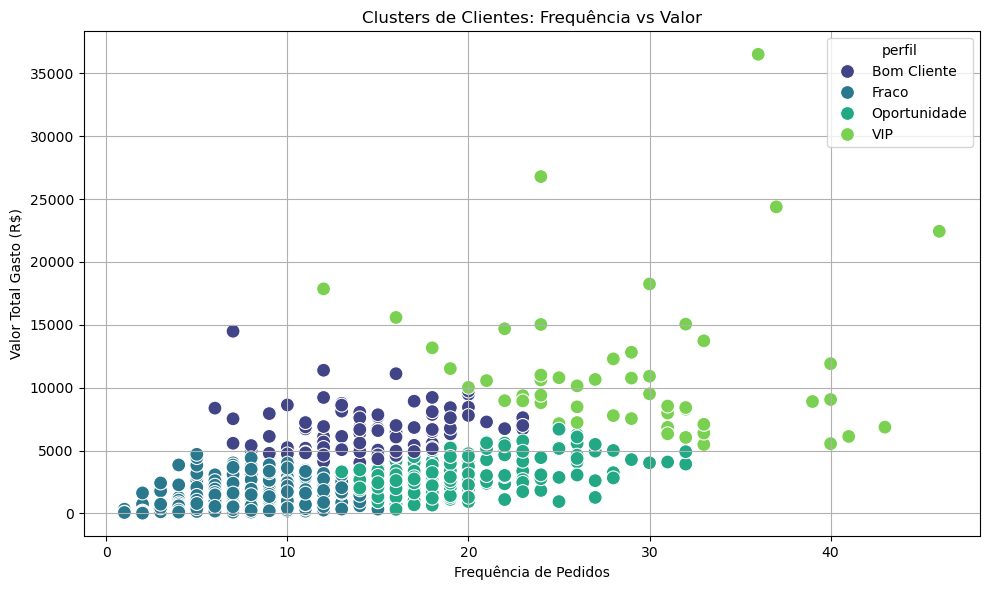

In [36]:
plt.figure(figsize=(10,6))
sea.scatterplot(
    data=rfm,
    x='frequencia', y='valor',
    hue='perfil',
    palette='viridis',
    s=100
)
plt.title('Clusters de Clientes: Frequência vs Valor')
plt.xlabel('Frequência de Pedidos')
plt.ylabel('Valor Total Gasto (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

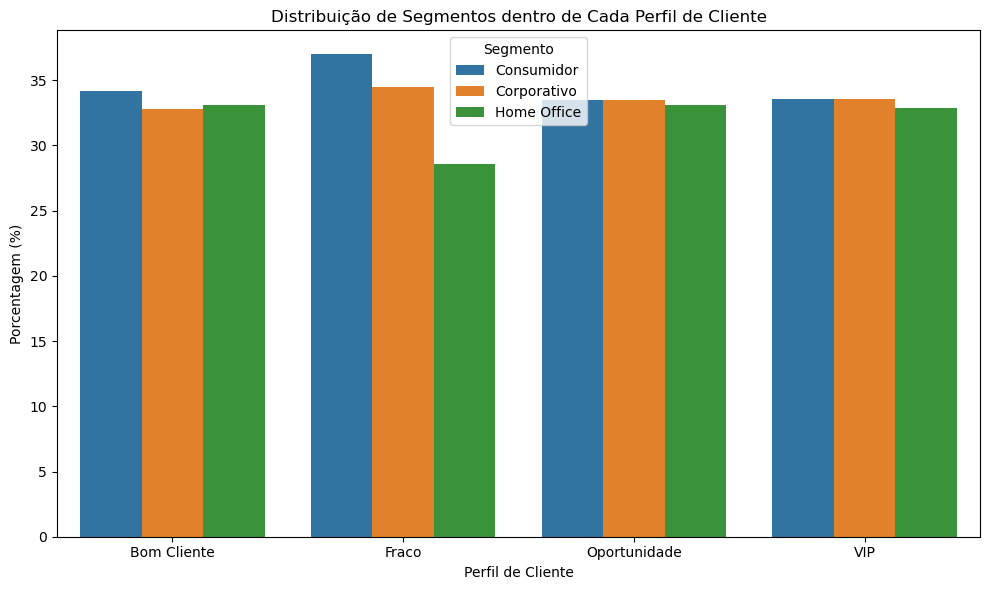

In [37]:
rfm = rfm.merge(
    df[['nome_cliente', 'segmento']].drop_duplicates(),
    left_on='cliente',
    right_on='nome_cliente',
    how='left'
)

rfm.drop(columns=['nome_cliente'], inplace=True)

segmento_por_perfil = rfm.groupby(['perfil', 'segmento']).size().reset_index(name='contagem')

total_por_perfil = segmento_por_perfil.groupby('perfil')['contagem'].transform('sum')

segmento_por_perfil['porcentagem'] = (segmento_por_perfil['contagem'] / total_por_perfil * 100).round(2)

plt.figure(figsize=(10, 6))
sea.barplot(
    data=segmento_por_perfil,
    x='perfil',
    y='porcentagem',
    hue='segmento'
)
plt.title('Distribuição de Segmentos dentro de Cada Perfil de Cliente')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Perfil de Cliente')
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()


Clientes VIP estão concentrados no canto superior direito, logo eles compram com frequência e gastam muito, dessa forma devem ser priorizados em programas de fidelidade, atendimento diferenciado e retenção.

Clientes Fracos estão no canto inferior esquerdo: baixa frequência e baixo valor, logo podem ser clientes ocasionais, desengajados ou novos, e talvez precisem de campanhas específicas.

Oportunidades fazem muitos pedidos, mas gastam pouco, logo  vale a pena analisar o tipo de produto que compram e tentar estratégias para aumentar o ticket médio.

Bons Clientes gastam bem, mesmo que não comprem com tanta frequência, logo podem ser impactados com campanhas de reativação ou engajamento.